<a href="https://colab.research.google.com/github/astopchatyy/Buildings-prediction-collab/blob/main/Buildings_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import copy
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from scipy.stats import zscore
from xgboost import XGBRegressor


Mounting google drive

In [84]:
drive.mount('/content/drive')
torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading train and test data

In [85]:
train_data = pd.read_csv('/content/drive/MyDrive/collab files/buildings dataset/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/collab files/buildings dataset/test.csv')

train_data.drop('Id', axis=1, inplace=True)
test_data.drop('Id', axis=1, inplace=True)


Checking data structure

In [86]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [87]:
for column in train_data.columns:
  s = train_data[column].isna().sum()
  if s > 0:
    print(f"{column}: type={train_data[column].dtype}, has {s} na`s")

LotFrontage: type=float64, has 259 na`s
Alley: type=object, has 1369 na`s
MasVnrType: type=object, has 872 na`s
MasVnrArea: type=float64, has 8 na`s
BsmtQual: type=object, has 37 na`s
BsmtCond: type=object, has 37 na`s
BsmtExposure: type=object, has 38 na`s
BsmtFinType1: type=object, has 37 na`s
BsmtFinType2: type=object, has 38 na`s
Electrical: type=object, has 1 na`s
FireplaceQu: type=object, has 690 na`s
GarageType: type=object, has 81 na`s
GarageYrBlt: type=float64, has 81 na`s
GarageFinish: type=object, has 81 na`s
GarageQual: type=object, has 81 na`s
GarageCond: type=object, has 81 na`s
PoolQC: type=object, has 1453 na`s
Fence: type=object, has 1179 na`s
MiscFeature: type=object, has 1406 na`s


Dropping columns with too many na`s

In [88]:
for column in train_data.columns:
  s = train_data[column].isna().sum()
  if s > len(train_data) * 0.8:
    train_data.drop(column, inplace=True, axis=1)
    test_data.drop(column, inplace=True, axis=1)

Some processing of na values

In [89]:
test_data['Electrical'].isna().sum()

0

In [90]:
train_data.dropna(subset=['Electrical'], inplace=True)
train_data['MasVnrArea'].fillna(0, inplace=True)

In [91]:
for column in train_data.columns:
  if train_data[column].dtype != np.dtype(object):
    s = train_data[column].isna().sum()
    if s > 0:
      print(f"{column}: type={train_data[column].dtype}, has {s} na`s")

LotFrontage: type=float64, has 259 na`s
GarageYrBlt: type=float64, has 81 na`s


In [92]:
for column in test_data.columns:
  if test_data[column].dtype != np.dtype(object):
    s = test_data[column].isna().sum()
    if s > 0:
      print(f"{column}: type={test_data[column].dtype}, has {s} na`s")

LotFrontage: type=float64, has 227 na`s
MasVnrArea: type=float64, has 15 na`s
BsmtFinSF1: type=float64, has 1 na`s
BsmtFinSF2: type=float64, has 1 na`s
BsmtUnfSF: type=float64, has 1 na`s
TotalBsmtSF: type=float64, has 1 na`s
BsmtFullBath: type=float64, has 2 na`s
BsmtHalfBath: type=float64, has 2 na`s
GarageYrBlt: type=float64, has 78 na`s
GarageCars: type=float64, has 1 na`s
GarageArea: type=float64, has 1 na`s


In [93]:
train_data['GarageYrBlt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [94]:
print(train_data['SalePrice'].corr(train_data['GarageYrBlt']))
print(train_data['GarageYrBlt'].corr(train_data['YearBuilt']))
print(train_data['SalePrice'].corr(train_data['YearBuilt']))

0.48679699191537557
0.8255032711686539
0.523273060585643


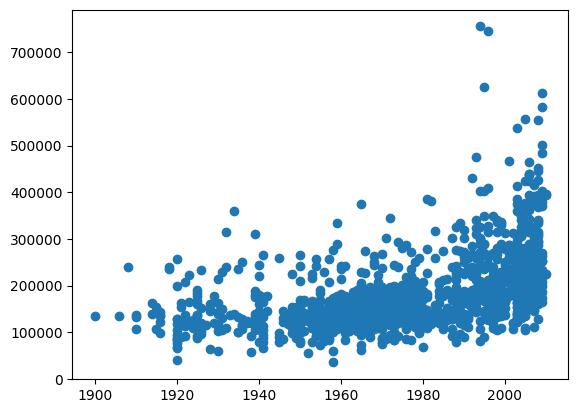

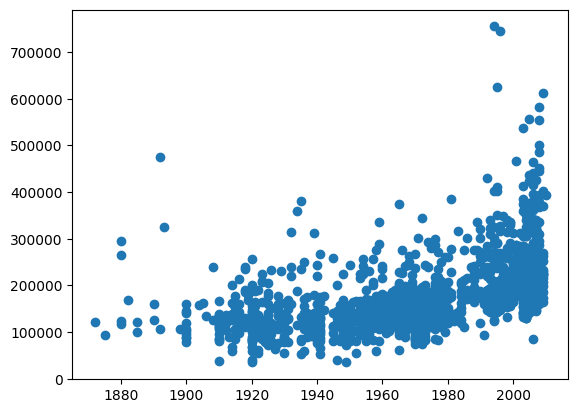

In [95]:
plt.plot(train_data['GarageYrBlt'].values, train_data['SalePrice'].values, 'o')
plt.show()
plt.plot(train_data['YearBuilt'].values, train_data['SalePrice'].values, 'o')
plt.show()

In [96]:
    train_data.drop('GarageYrBlt', inplace=True, axis=1)
    test_data.drop('GarageYrBlt', inplace=True, axis=1)

Splitting SalePrice

In [97]:
target = pd.DataFrame(train_data['SalePrice'])
train_data = train_data.drop('SalePrice',axis=1)

Creating dummies for categorical columns

In [98]:
for column in train_data.columns:
  if train_data[column].dtype == np.dtype(object) or column == 'MSSubClass':
    train_data = pd.concat([train_data, pd.get_dummies(train_data[column], prefix=column, dtype=int)], axis=1)
    train_data.drop(column, axis=1, inplace=True)
    test_data = pd.concat([test_data, pd.get_dummies(test_data[column], prefix=column, dtype=int)], axis=1)
    test_data.drop(column, axis=1, inplace=True)

test_missing_columns = set(train_data.columns) - set(test_data.columns) - {'SalePrice'}
train_missing_columns = set(test_data.columns) - set(train_data.columns)
for column in test_missing_columns:
    test_data[column] = 0
for column in train_missing_columns:
    train_data[column] = 0
test_data = test_data[train_data.columns]

In [99]:
for column in train_data.columns:
  s = train_data[column].isna().sum()
  if s > 0:
    print(f"{column}: type={train_data[column].dtype}, has {s} na`s")

LotFrontage: type=float64, has 259 na`s


Numerical columns nas imputation using KNNImputer

In [100]:
imputer = KNNImputer(n_neighbors=2)
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(imputer.fit_transform(test_data), columns=test_data.columns)

In [101]:
for column in test_data.columns:
  s = test_data[column].isna().sum()
  if s > 0:
    print(f"{column}: type={test_data[column].dtype}, has {s} na`s")

Processing outliers

In [102]:
numeric_columns = []
for column in train_data.columns:
  if len(train_data[column].unique()) > 10:
    numeric_columns.append(column)
print(numeric_columns)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold']


array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>,
        <Axes: title={'center': 'GarageArea'}>],
       [<Axes: title={'center': 'WoodDeckSF'}>,
        <Axes: title={'center': 'OpenPorchSF'}>,
        <Axes: title={'center': 'EnclosedPorch'}>,
        <Axes: title={'center': '3SsnPorch'}>,
        <Axes: title={'center': 'ScreenPorch'}>],
       [<Axes: title={'center': 'M

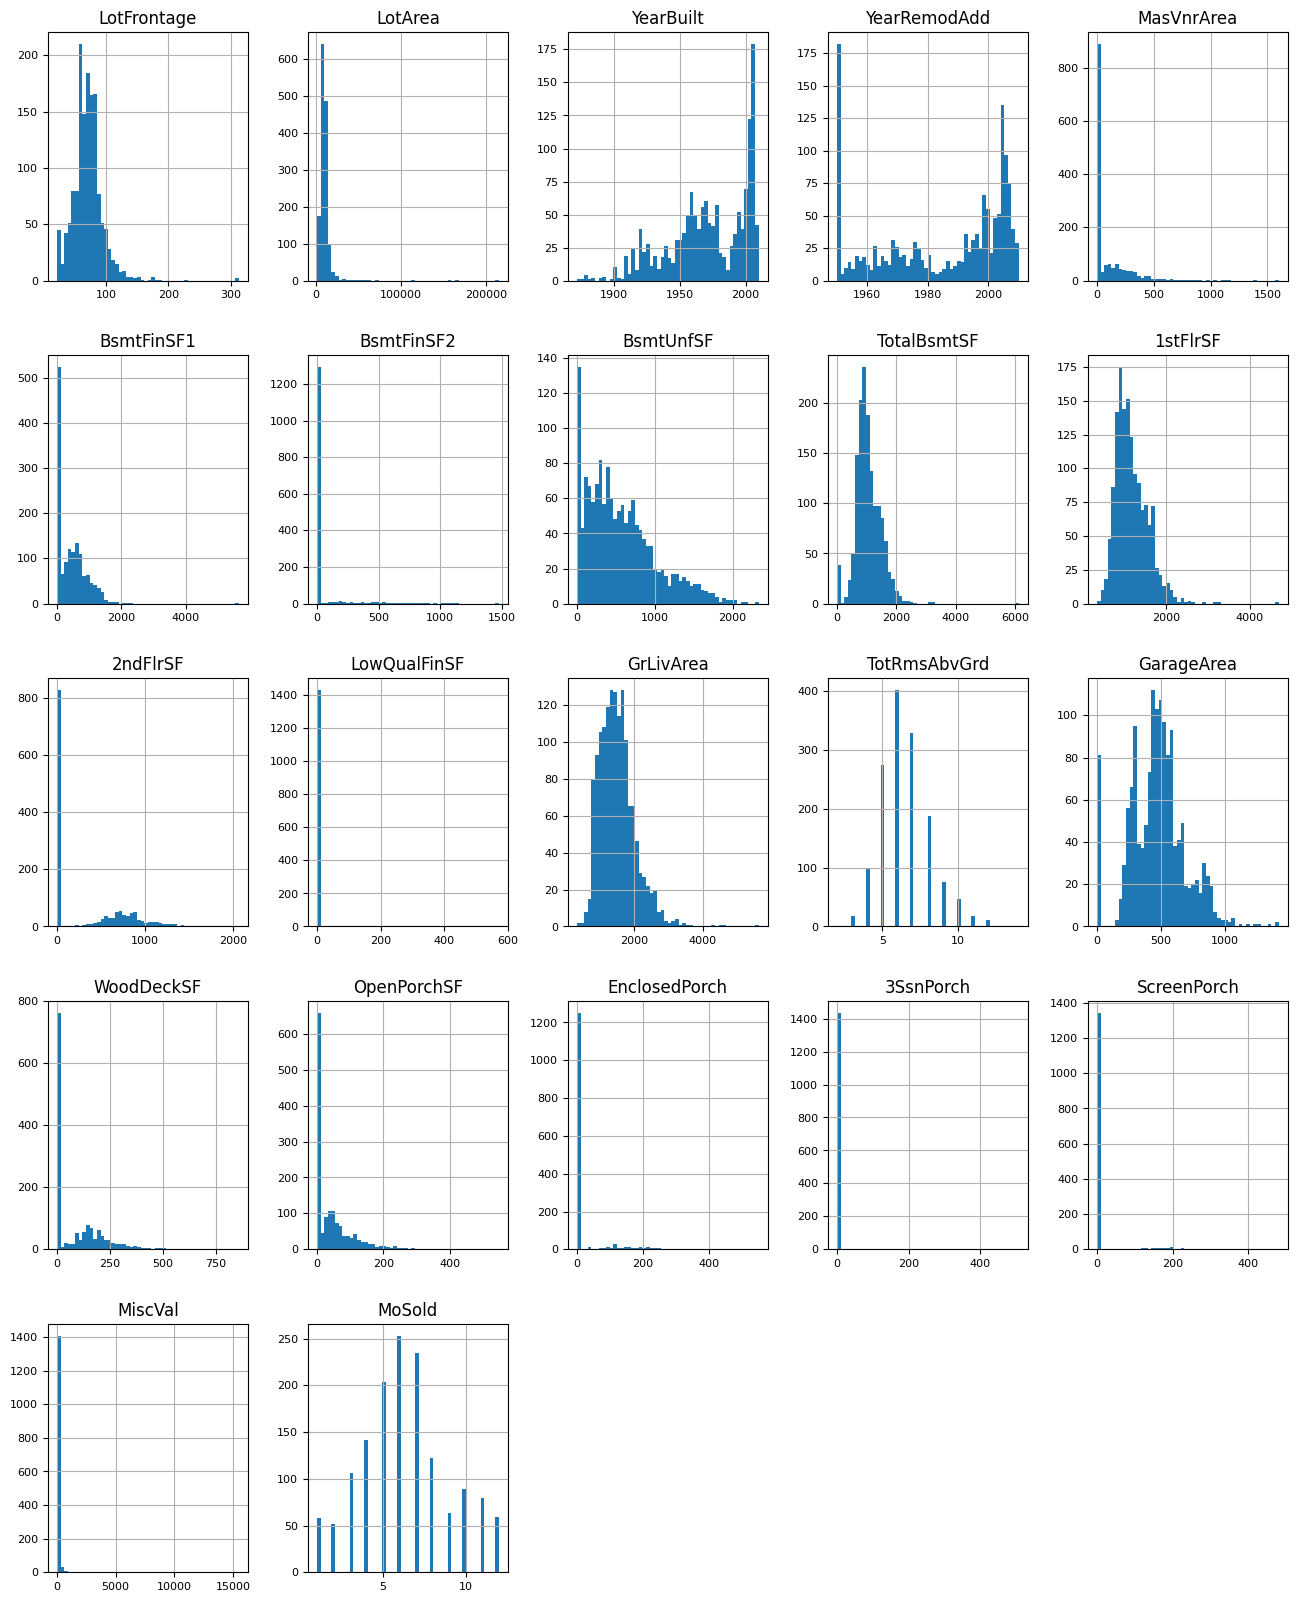

In [103]:
train_data[numeric_columns].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

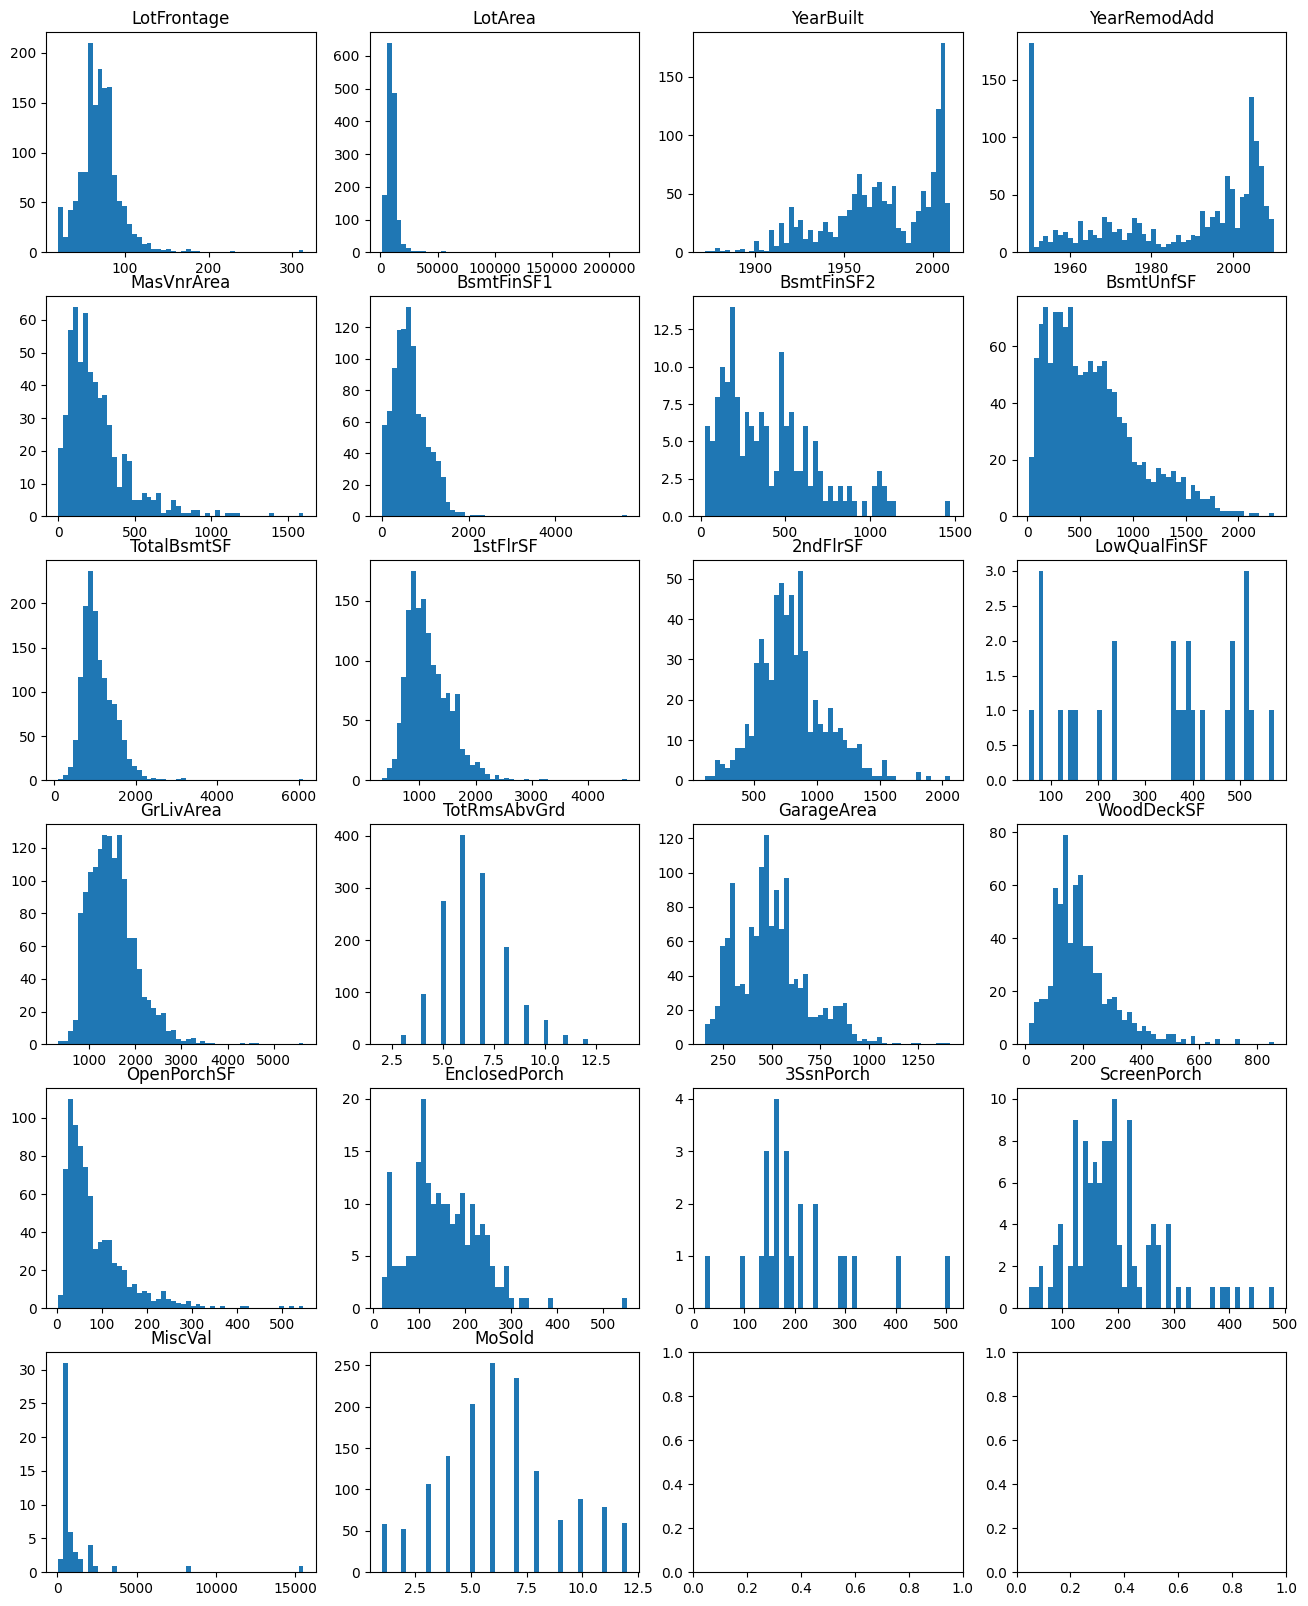

In [104]:
train_data_visualization = train_data[numeric_columns]

fig, plots = plt.subplots(6, 4, figsize=(16, 20))
plots = plots.reshape(24)


for i, column in enumerate(train_data_visualization.columns):
  data = train_data_visualization[column][train_data_visualization[column] > 0].values
  plots[i].hist(data, bins=50)
  plots[i].set_title(column)


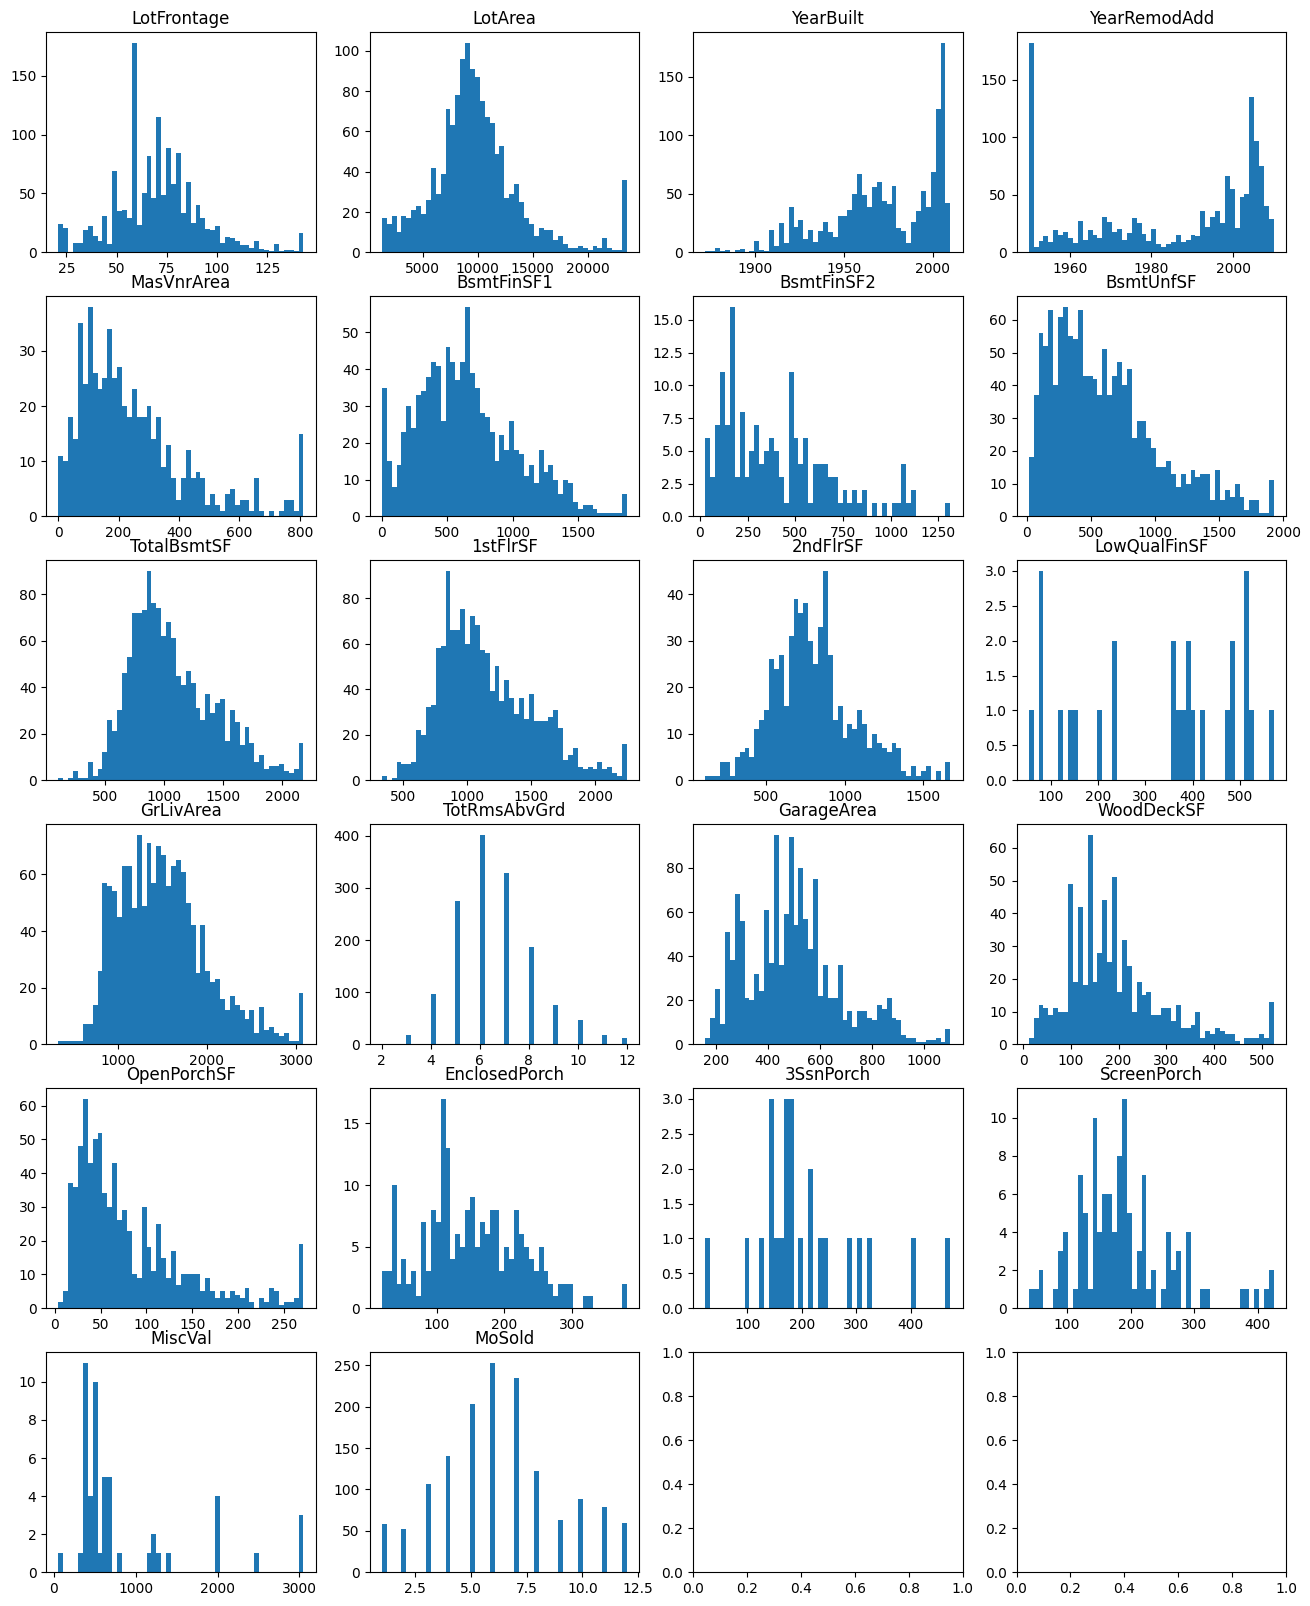

In [105]:
fig, plots = plt.subplots(6, 4, figsize=(16, 20))
plots = plots.reshape(24)

brackets = dict()


for i, column in enumerate(train_data_visualization.columns):
  data = train_data_visualization[column][train_data_visualization[column] > 0]
  quantiles = data.quantile([0.05, 0.95]).values

  brackets[column] = (quantiles[1] - quantiles[0]) + data.median()
  data = data.clip(upper=brackets[column])

  plots[i].hist(data, bins=50)
  plots[i].set_title(column)

In [106]:
for column in numeric_columns:
  train_data[column].clip(upper=brackets[column], inplace=True)
  test_data[column].clip(upper=brackets[column], inplace=True)

In [29]:
#Converts pandas DataFrame, pandas Series or numpy ndarray to torch.tensor
def to_tensor(x):
    if isinstance(x, pd.DataFrame) or isinstance(x, pd.Series):
      x = x.values
    if not torch.is_tensor(x):
      device = "cuda" if torch.cuda.is_available() else "cpu"
      x = torch.tensor(x, device=device, dtype=torch.float32)
    return x

#Converts torch.tensor to numpy ndarray
def to_numpy(x):
  if torch.is_tensor(x):
    return x.detach().cpu().numpy()
  elif isinstance(x, np.ndarray):
    return x
  return np.array(x)

def weight_reset(layer):
  if isinstance(layer, torch.nn.Linear) or isinstance(layer, torch.nn.Conv2d):
    layer.reset_parameters()

In [68]:
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

#torch nn adapter class for sklearn methods
class TorchModelRegressor(BaseEstimator):
  def __init__(self, model=None, loss_function=None, optim='Adam', learning_rate=0.01, max_epoch=500, random_state=None, warm_start=False):
    self.model = model
    self.loss_function = loss_function
    self.optim = optim
    self.learning_rate = learning_rate
    self.max_epoch = max_epoch
    self.random_state = random_state
    self.warm_start = warm_start


  def fit(self, X, y):

    X, y = check_X_y(X, y)
    self.is_fitted_ = True
    self.n_features_in_ = X.shape[1]

    if not self.model is None:
      if not self.random_state is None:
        torch.manual_seed(self.random_state)

      self.setup()

      X = to_tensor(X)
      y = to_tensor(y).reshape(-1, 1)

      for epoch in range(self.max_epoch):
        self.step(X, y)
      self.last_epoch += epoch
    return self


  def step(self, x, y):
    self.model.train()
    self.optimizer.zero_grad()
    out = self.model(x)
    loss = self.loss_function(out, y)
    loss.backward()
    self.optimizer.step()

  def setup(self):
    self.optimizer = torch.optim.Adam(self.model.parameters(), self.learning_rate)

    if self.loss_function is None:
      self.loss_function = torch.nn.MSELoss()

    if not self.warm_start:
      self.model.apply(weight_reset)

    if hasattr(self, 'last_epoch_') and self.warm_start:
      self.last_epoch += self.last_epoch_
    else:
      self.last_epoch = 0
    if not hasattr(self, 'device_'):
      self.device_ = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device_)
      self.loss_function.to(self.device_)


  def predict(self, X):
    check_is_fitted(self)

    X = check_array(X)

    if self.model is None:
      return X
    X = to_tensor(X)
    self.model.eval()
    return to_numpy(self.model(X))

Check class by check_estimator method


In [20]:
from sklearn.utils.estimator_checks import check_estimator
print(check_estimator(TorchModelRegressor()))

None


Test if clone method works correctly

In [71]:
from sklearn.base import clone
m1 = torch.nn.Sequential(
    torch.nn.Linear(4, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
    )

reg1 = TorchModelRegressor(model=m1)

reg1.fit([[1,2,3,4]],[1])

reg2 = clone(reg1)

reg2.fit([[1,2,3,4]],[2])

print(reg1.predict([[1,2,3,4]]))
print(reg2.predict([[1,2,3,4]]))

[[1.]]
[[2.]]
